# Nonlinear Optimization

In this notebook, we explore optimization methods using a practical example rooted in real-world data: win probabilities in chess based on ELO ratings. This dataset, which you previously encountered in the Bayesian linear regression question, provides a compelling foundation for understanding the strengths and limitations of different modeling techniques.

While a simple linear model can work reasonably well for small ELO differences, it struggles as the differences grow, predicting probabilities that fall outside the valid [0, 1] range. To address this, we shift to a non-linear approach using a sigmoid function as our template. Unlike linear models, the sigmoid function ensures outputs remain bounded between 0 and 1, making it inherently suitable for probability estimation. Moreover, this function's parameterization introduces non-linear transformations, allowing the model to adapt more flexibly by scaling, shifting, and stretching in ways that a simple linear slope cannot achieve.

The goal of this notebook is not only to showcase optimization methods but also to demonstrate how they interact with non-linear parameter spaces and adapt to complex modeling challenges. By the end, you'll have a deeper understanding of how optimization techniques can be applied to real data and why non-linear parameterization is essential for practical and robust predictive modeling.

**Your task**  
This notebook provides a starter code for an implementation of nonlinear optimization methods for an objective function.

Please add this notebook to your Google Drive and complete all designated sections accordingly.

It is best to create a folder in your Google Drive to hold your Colaboratory assignments. Please include your .ipynb file with your assignment submission.

# Headers and Data
Just run the cells in this section to prepare the notebook.
You don't have to make changes here, but
feel free to add any further modules here.

In [1]:
from math import sqrt
from numpy import asarray
from numpy import arange
from numpy import meshgrid
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# The x and y dimensions in this dataset

data_x = np.array([[-139.15341508, -681.19390135,  374.83381147,  461.45761931,
       -205.65507596,    7.52847535, -551.03494308,  659.15105943,
       -215.83519299, -341.60486674,  590.2827852 ,  648.04672811,
        393.6312089 ,  190.73955575,  388.96338453, -252.161518  ,
       -251.64298135, -657.19690255, -352.94565567, -178.58059633,
        304.90248582]])
data_y = np.array([[0.44610327, 0.1444    , 0.7737475 , 0.81391054, 0.24666655,
       0.49943957, 0.12402231, 0.93239468, 0.28009304, 0.14202444,
       0.88360894, 0.84497416, 0.72092098, 0.6790719 , 0.84907639,
       0.24405219, 0.27233288, 0.13289914, 0.25335661, 0.34657246,
       0.78085279]])

# The data source: Database of standard rated games, played on lichess.org
# https://database.lichess.org/standard/lichess_db_standard_rated_2013-03.pgn.zst
# x in the above data are ELO differences for White ELO - Black ELO
# y is the win probability sampled from a probabilistic model from Liches DB


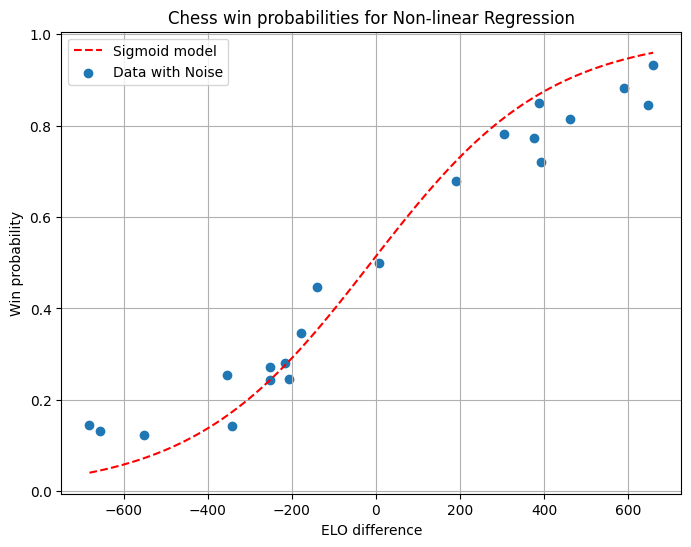

In [3]:
# Mean parameter values from MCMC samples of the full data model
sigmoid_beta_mean = 0.00472924
sigmoid_intercept_mean = 0.05645535

def show_model_on_data(sigmoid_beta_mean=None, sigmoid_intercept_mean=None,
                       model_name="Sigmoid model", fun=None, show_data=True,
                       **plot_kwargs):
    """
    Plots a model's predicted win probabilities for chess outcomes based on ELO differences.

    Parameters:
    - sigmoid_beta_mean (float): Coefficient for the ELO difference (slope of the model).
    - sigmoid_intercept_mean (float): Intercept term of the model.
    - model_name (str): Label for the model line in the plot.
    - fun (callable, optional): A function to compute model predictions from ELO differences.
      If None, a default sigmoid model using `sigmoid_beta_mean` and `sigmoid_intercept_mean` is used.
    - show_data (bool): Whether to display the original data points in the plot.
    - **plot_kwargs: Additional keyword arguments to customize the appearance of the model line.

    Returns:
    - None: The function generates a plot.
    """
    # Define the range for ELO differences for plotting the model
    elo_diff_range = np.linspace(data_x.min(), data_x.max(), 100)
    y_plot = data_y.flatten()
    x_plot = data_x.flatten()

    if fun is None:
        # Default model calculation using sigmoid parameters
        logits = sigmoid_beta_mean * elo_diff_range + sigmoid_intercept_mean
        true_win_probabilities = np.exp(logits) / (1 + np.exp(logits))
    else:
        # Model calculation using the provided function
        true_win_probabilities = fun(elo_diff_range)

    # Plot the model line with optional customization
    plt.plot(elo_diff_range, true_win_probabilities,
             linestyle='--', label=model_name, **plot_kwargs)

    # Optionally plot the original data
    if show_data:
        plt.scatter(x_plot, y_plot, label='Data with Noise')
        plt.xlabel('ELO difference')
        plt.ylabel('Win probability')
        plt.title('Chess win probabilities for Non-linear Regression')
        plt.legend()
        plt.grid(True)

# Lambda function shortcut for plotting the default sigmoid model
show_sigmoid_on_data = lambda beta, intercept: show_model_on_data(beta, intercept, color='red')

# Example usage of the plotting function
plt.figure(figsize=(8, 6))
show_sigmoid_on_data(sigmoid_beta_mean, sigmoid_intercept_mean)


# Objective Function
Modify the "objective" function using one of the following options.

(i) [simplified, fallback] use this example function and find its optimum:

$$f(x,y) = x^{2} + \dfrac{(y-2)^2}{2}$$

(ii) [complete] use a suitable loss function that determines the fit of the sigmoid function template with the given data.

You do not have to implement both, (ii) alone is considered a complete solution. However, in case you get stuck implementing the loss and its derivative, we are also accepting notebooks that just optimize (i) with a mild deduction (likely -5%) for this part of the assignment.

### Cross-Entropy Loss Function

The cross-entropy loss for binary classification is defined as:

$$
\text{Loss} = -\sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

where:
- $N$ is the number of data points,
- $y_i$ is the true target probability value $\in [0,1]$,
- $\hat{y}_i$ is the predicted probability from the sigmoid function:
$$
\hat{y}_i = \frac{1}{1 + e^{-z_i}}
$$
- where the logits $z_i$ are formed as
$$ z_i = \beta \cdot x_i + \text{intercept} $$

#### Derivative of Cross-Entropy Loss with Respect to $z_i$

The partial derivative of the cross-entropy loss with respect to $z_i$ yields a surprisingly simple result:
$$
\frac{\partial \text{Loss}_i}{\partial z_i} = \hat{y}_i - y_i
$$

With this, and understanding how $z_i$ depends on the parameters $\beta$ and the intercept, you can construct the gradient for the loss with respect to each of these parameters using the chain rule.

### Mapping the parameter range for the loss function
If you create functions for the loss objective and its gradient, we need to rescale the parameter domain so both parameters are conveniently explored in the larger bounds from -15 to 15, rather than their original scaling.
Please do not change the helper functions in the next cell.

In [4]:
import numpy as np

# Define bounds for mapping
large_bounds = [[-15.0, 15.0], [-15.0, 15.0]]  # Large exploration source bounds
small_bounds = [[0.0, 0.01], [-1.0, 1.0]]      # Target bounds to explore in original scaling

# Mapping function: Maps (beta, intercept) from the source range to the target range
def map_to_target_range(beta, intercept, source_bounds, target_bounds):
    beta_mapped = (beta - source_bounds[0][0]) / (source_bounds[0][1] - source_bounds[0][0]) * (target_bounds[0][1] - target_bounds[0][0]) + target_bounds[0][0]
    intercept_mapped = (intercept - source_bounds[1][0]) / (source_bounds[1][1] - source_bounds[1][0]) * (target_bounds[1][1] - target_bounds[1][0]) + target_bounds[1][0]
    return beta_mapped, intercept_mapped

# Rescaling gradients based on mapping
def rescale_gradients(grad_beta, grad_intercept, large_bounds, small_bounds):
    beta_scale = (small_bounds[0][1] - small_bounds[0][0]) / (large_bounds[0][1] - large_bounds[0][0])
    intercept_scale = (small_bounds[1][1] - small_bounds[1][0]) / (large_bounds[1][1] - large_bounds[1][0])
    grad_beta_rescaled = grad_beta * beta_scale
    grad_intercept_rescaled = grad_intercept * intercept_scale
    return grad_beta_rescaled, grad_intercept_rescaled

## Demo code for the above helper functions

# # Map a sample input (beta, intercept) from the large to the small range
# beta_mapped, intercept_mapped = map_to_target_range(5.0, 10.0, large_bounds, small_bounds)
# print("Mapped beta:", beta_mapped, "Mapped intercept:", intercept_mapped)

# # Example gradients from the original function
# grad_beta, grad_intercept = 0.5, 0.3
# grad_beta_rescaled, grad_intercept_rescaled = rescale_gradients(grad_beta, grad_intercept, large_bounds, small_bounds)
# print("Rescaled gradients -> beta:", grad_beta_rescaled, "intercept:", grad_intercept_rescaled)


Implement the objective for simple function $f$ from option (i) above, or comment this cell

In [5]:
# def objective(x, y):
# 	# <<simpler TODO #1>> modify the objective function to implement the simple f
# 	return 1


If you decide to aim for the complete solution, please provide objective and gradient for the cross-entropy loss function discussed above.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z))

# Objective Function (Cross-Entropy Loss for Sigmoid Model)
def objective_loss(beta, intercept, x, y):
    # Map beta and intercept from the large space to the constrained space
    beta, intercept = map_to_target_range(beta, intercept, large_bounds, small_bounds)

    # <<complete TODO #1>> calculate the loss function below
    
    # calc logit z = beta * x + intercept
    z = np.dot(beta, x) + intercept

    # Calc the sigmoid predictions
    y_pred = sigmoid(z)

    # Cross-entropy loss calculation
    loss = -np.mean((y) * np.log(y_pred) + (1-y) * np.log(1-y_pred))
    return loss

# The line below does 2 things:
# a) bind the dataset parameters,
# b) vectorize the resulting function of beta and intercept, so it works on vector inputs, elementwise
objective = np.vectorize(lambda beta, intercept: objective_loss(beta, intercept, data_x.flatten(), data_y.flatten()))

# Flatten x and y for usage
x_flat = data_x.flatten()
y_flat = data_y.flatten()

# Calculate the loss for given beta and intercept
large_sigmoid_beta_mean, large_sigmoid_intercept_mean = map_to_target_range(sigmoid_beta_mean, sigmoid_intercept_mean, small_bounds, large_bounds)
loss = objective(large_sigmoid_beta_mean, large_sigmoid_intercept_mean)
print("Cross-Entropy Loss:", loss)


Cross-Entropy Loss: 0.5334532918317411


# Gradient of objective function
Modify the "gradient" function accordingly.

In [7]:
def gradient(x, y):
	# <<TODO #2 simple>> modify the gradient function
	return 1

def gradient_for_data(beta, intercept, x, y):
    """
    Calculate gradients of cross-entropy loss with respect to beta and intercept.

    Args:
        beta (float): Slope parameter
        intercept (float): Intercept parameter
        x (array): Input features
        y (array): Target values (0 or 1)

    Returns:
        tuple: (gradient_beta, gradient_intercept)
    """
    # Map beta and intercept from the large space to the target space
    beta, intercept = map_to_target_range(beta, intercept, large_bounds, small_bounds)

    # <<TODO #2 complete>> implement the cross-entropy loss function gradient

    # Calc logits z = beta * x + intercept
    z = np.dot(x, beta) + intercept

    # Compute predicted probabilities using the sigmoid function
    y_pred = sigmoid(z)
    
    # Gradient of loss wrt z (partial derivative)
    grad_z = y_pred - y  
    
    # Gradient w.r.t. beta and intercept (using chain rule and vectorized format)
    # multiplying by N for normalizing the gradient to compute the average loss
    grad_beta = np.dot(x.T, grad_z) / len(y)  # wrt beta
    grad_intercept = np.mean(grad_z)          # wrt intercept
    
    # Rescale gradients to the lensed space
    grad_beta_rescaled, grad_intercept_rescaled = rescale_gradients(grad_beta, grad_intercept, large_bounds, small_bounds)

    return np.array([grad_beta_rescaled, grad_intercept_rescaled])

# bind the data parameters, comment this to not overwrite simple version
gradient = lambda beta, intercept: gradient_for_data(beta, intercept, data_x.flatten(), data_y.flatten())

#Part a: Plot the objective function
Use the following block to plot the objective function. Please do not modify it.

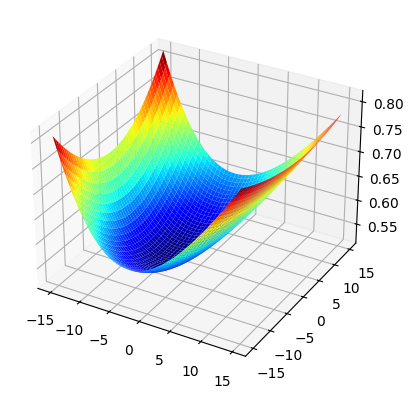

In [8]:
# define range for input
bounds = asarray([[-15.0, 15.0], [-15.0, 15.0]])
# sample input range uniformly at 0.1 increments
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# Figure 1
# create a surface plot with the jet color scheme
figure_1 = pyplot.figure(1)
axis = figure_1.add_subplot(projection='3d')
axis.plot_surface(x, y, objective(x, y), cmap='jet')

#Part b: Basic Gradient Descent


## b.1. Set Parameters
You may change the following parameters.

In [27]:
# define the total iterations
n_iter = 100
# steps size
gamma_t = 0.2

##b.2. Gradient Descent Function
Modify the following function to implement a basic gradient descent approach.

In [28]:
# we will iteratively update the parameters β and the intercept using the gradients. 

def gradient_descent(objective, derivative, bounds, n_iter, gamma_t):
    # track all solutions, gradients
    solutions = list()
    # Consider an initial point
    p = [-10, 10] # [beta, intercept]
    score = objective(p[0], p[1])
    # run the gradient descent
    for t in range(n_iter):
        # report progress
        print('>%d f(%s) = %.5f' % (t, p, score))

        # <<TODO#3>> Add your code here

        # Compute gradient at current point
        grad = derivative(p[0], p[1])

        # Update parameters using the gradient and step size
        p[0] = p[0] - gamma_t * grad[0]
        p[1] = p[1] - gamma_t * grad[1]

        # Append the current point to solutions
        solutions.append(p.copy())

        # Evaluate the new score
        score = objective(p[0], p[1])

    return solutions


##b.3. Solve the Problem using Gradient Descent
Use the following block to solve the problem. Please do not modify it.

In [29]:
# perform the gradient descent search
solutions = gradient_descent(objective, gradient, bounds, n_iter, gamma_t)
solutions = asarray(solutions)

>0 f([-10, 10]) = 0.60920
>1 f([-9.996355027123988, 9.997969705040687]) = 0.60912
>2 f([-9.992712891907765, 9.99594003392186]) = 0.60903
>3 f([-9.989073591714401, 9.993910986390256]) = 0.60894
>4 f([-9.985437123909659, 9.991882562192442]) = 0.60886
>5 f([-9.981803485861981, 9.989854761074826]) = 0.60877
>6 f([-9.978172674942499, 9.987827582783652]) = 0.60868
>7 f([-9.974544688525025, 9.985801027065005]) = 0.60860
>8 f([-9.970919523986053, 9.98377509366481]) = 0.60851
>9 f([-9.967297178704753, 9.981749782328837]) = 0.60842
>10 f([-9.963677650062973, 9.979725092802694]) = 0.60834
>11 f([-9.960060935445235, 9.977701024831838]) = 0.60825
>12 f([-9.95644703223873, 9.975677578161571]) = 0.60817
>13 f([-9.952835937833322, 9.973654752537042]) = 0.60808
>14 f([-9.949227649621545, 9.971632547703246]) = 0.60800
>15 f([-9.945622164998593, 9.969610963405032]) = 0.60791
>16 f([-9.942019481362328, 9.967589999387094]) = 0.60782
>17 f([-9.938419596113272, 9.965569655393983]) = 0.60774
>18 f([-9.9348225

##b.4. Plot results for Basic Gradient Descent
Use the following block to plot the results. Please do not modify it.

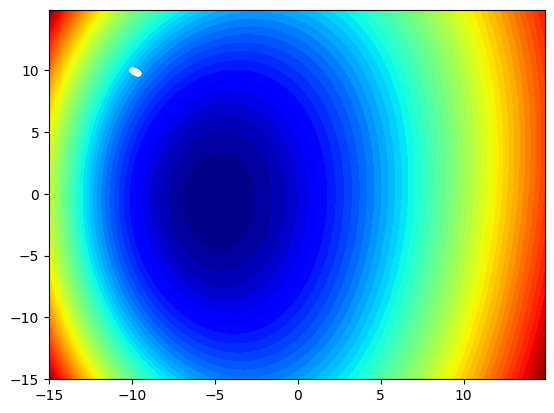

In [30]:
# Figure 2
# create a filled contour plot with 50 levels and jet color scheme
figure_2 = pyplot.figure(2)
pyplot.contourf(x, y, objective(x, y), levels=50, cmap='jet')
# plot the solution
pyplot.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')
# show the plot
pyplot.show()

#Part c: Adam

##c.1. Set Parameters
You may change the following parameters.

In [31]:
eps=1e-8
# define the total iterations
n_iter = 150
# steps size
gamma_t = 0.2
# factor for average gradient
alpha = 0.8
# factor for average squared gradient
beta = 0.999

##c.2. Adam Function
Modify the following function to implement the Adam approach.

In [32]:
def adam(objective, derivative, bounds, n_iter, gamma_t, alpha, beta, eps):
    solutions = list()
    # generate an initial point
    p = [-10, 10] # [beta, intercept]
    score = objective(p[0], p[1])
    # initialize first and second moments
    m = [0.0 for _ in range(bounds.shape[0])]
    D = [0.0 for _ in range(bounds.shape[0])]
    # run the Adam updates
    for t in range(1, n_iter + 1):
        # report progress
        print('>%d f(%s) = %.5f' % (t, p, score))
        # <<TODO#4>> Add your code here

        # Compute gradient at current point (beta, intercept)
        grad = derivative(p[0], p[1])

        # Update 1st and 2nd moments
        m = [alpha * m[i] + (1 - alpha) * grad[i] for i in range(bounds.shape[0])]
        D = [beta * D[i] + (1 - beta) * (grad[i] ** 2) for i in range(bounds.shape[0])]

        # bias update 
        m_hat = [m[i] / (1 - alpha ** t) for i in range(bounds.shape[0])]
        D_hat = [D[i] / (1 - beta ** t) for i in range(bounds.shape[0])]

        # updating paramters 
        p = [p[i] - gamma_t * (m_hat[i] / (np.sqrt(D_hat[i]) + eps)) for i in range(bounds.shape[0])]

        # finding the new score 
        score = objective(p[0], p[1])

        # appending to the solution 
        solutions.append(p.copy())

    return solutions

##c.3. Solve the Problem using Adam
Use the following block to solve the problem. Please do not modify it.

In [33]:
# perform the adam search
solutions = adam(objective, gradient, bounds, n_iter, gamma_t, alpha, beta, eps)
solutions = asarray(solutions)

>1 f([-10, 10]) = 0.60920
>2 f([-9.800000109740125, 9.800000197015514]) = 0.60363
>3 f([-9.600551346906942, 9.600294634957084]) = 0.59829
>4 f([-9.402042092052511, 9.401086009275723]) = 0.59317
>5 f([-9.204870611433307, 9.202578737042982]) = 0.58828
>6 f([-9.009439993944916, 9.004976354305498]) = 0.58363
>7 f([-8.816152953877761, 8.808478971121433]) = 0.57921
>8 f([-8.625406669120945, 8.613280869401496]) = 0.57503
>9 f([-8.437587815885783, 8.419568317740193]) = 0.57107
>10 f([-8.253067943429736, 8.227517662620263]) = 0.56735
>11 f([-8.072199307768802, 8.037293738220173]) = 0.56385
>12 f([-7.895311254514273, 7.849048619122316]) = 0.56056
>13 f([-7.722707210367222, 7.662920722946084]) = 0.55749
>14 f([-7.55466231283091, 7.479034254479619]) = 0.55462
>15 f([-7.391421680294167, 7.297498970067947]) = 0.55194
>16 f([-7.233199301174356, 7.118410231272004]) = 0.54945
>17 f([-7.080177502080458, 6.941849310240481]) = 0.54713
>18 f([-6.932506941225425, 6.767883905655576]) = 0.54498
>19 f([-6.7903

## c.4. Plot results for Adam (or Gradient Descent)
Use the following block to plot the results. Please do not modify it.

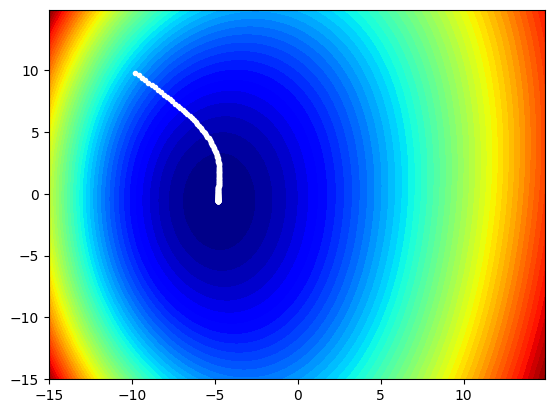

In [34]:
# Figure 4
# create a filled contour plot with 50 levels and jet color scheme
figure_4 = pyplot.figure(4)
pyplot.contourf(x, y, objective(x, y), levels=50, cmap='jet')
# plot the solution
pyplot.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')
# show the plot
pyplot.show()

# Plot the best fit function

In [35]:
lensed_beta, lensed_intercept = solutions[-1,:] # take last solution as best
best_beta, best_intercept = map_to_target_range(lensed_beta, lensed_intercept, large_bounds, small_bounds)
#best_beta, best_intercept = lensed_beta, lensed_intercept # use this if you're optimizing simple f
best_beta, best_intercept

(0.003389346955359509, -0.03871501754339102)

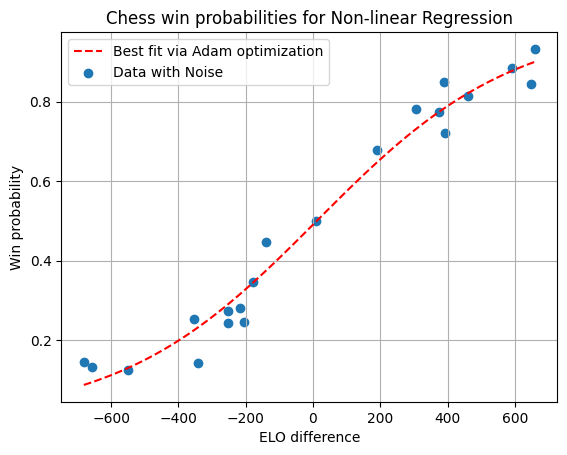

In [36]:

show_model_on_data(best_beta, best_intercept,
                   model_name="Best fit via Adam optimization",
                   color='red')
